# Tutorial 7b: Model selection II

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t7b_model_selection_2.ipynb).*

In [1]:
import itertools
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reminder of Bayesian model selection problem

As a reminder, our goal is to compute the probability that a given model is true, given the data.  By Bayes's theorem, this is

\begin{align}
P(M_i\mid D, I) = \frac{P(D \mid M_i, I)\,P(M_i\mid I)}{P(D\mid I)}.
\end{align}

Unless we can somehow sum probabilities over all models to compute

\begin{align}
P(D\mid I) = \sum_{i\in\text{all models}} P(D \mid M_i, I)\,P(M_i\mid I),
\end{align}

we cannot compute P(M_i\mid D, I).  Instead, we compare a pair of models, $M_i$ and $M_j$, by computing the odds ratio,

\begin{align}
O_{ij} = \frac{P(M_i\mid I)}{P(M_j\mid I)}\,\frac{P(D\mid M_i, I)}{P(D\mid M_j,I)}.
\end{align}

The second fraction in this equation is the evidence from the parameter estimation problem.  By Bayes's theorem, we have, for the parameter estimation problem,

\begin{align}
P(\mathbf{a}_i\mid D, M_i, I) = \frac{P(D\mid \mathbf{a}_i, M_i, I)\,P(\mathbf{a}_i\mid M_i, I)}{P(D\mid M_i, I)},
\end{align}

where the parameters are $\mathbf{a}_i$.  Because the posterior of the parameter estimation problem must be normalized,

\begin{align}
P(D\mid M_i, I) = \int \mathrm{d}\mathbf{a}_i\,P(D\mid \mathbf{a}_i, M_i, I)\,P(\mathbf{a}_i\mid M_i, I).
\end{align}

In [Tutorial 5a](http://bebi103.caltech.edu/2015/tutorials/t5a_model_selection_1.html), we evaluated this integral by approximating the posterior as sharply peaked and then using the Laplace approximation to compute the integral.  We found, however, that we run into trouble when the sharply-peaked assumption breaks down.  To remedy this, we showed in [lecture 6](http://bebi103.caltech.edu/2015/lecture_notes/l06_ptmcmc.pdf) that we can use parallel-tempering Markov chain Monte Carlo (PTMCMC) to compute the integral.  Once we have done this, we only need to specify our prior belief in the respective models, and we have then computed the odds ratio without approximation.

## The data set
We will revisit the data of Singer, et al, which you can download [here](../data/singer_transcript_counts.csv).  As a reminder, Singer and coworkers used single molecule FISH to get mRNA transcript counts of four different genes in each cell in a population of mouse embryonic stem cells.  The distribution of mRNA counts in a given cell is negative binomially distributed.

\begin{align}
P(n\mid r, p) = \frac{\Gamma(n+r)}{n!\,\Gamma(r)}\,p^{r}(1-p)^{n}.
\end{align}

If there are two different cell types that express the gene differently, the distribution is a linear combination of negative binomials,

\begin{align}
P(n\mid r_1, p_1, r_2, p_2, f) = 
f\,\frac{\Gamma(n+r_1)}{n!\,\Gamma(r_1)}\,p_1^{r_1}(1-p_1)^{n}
+ (1-f) \frac{\Gamma(n + r_2)}{n!\,\Gamma(r_2)}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

We can visually inspect the ECDFs of the mRNA counts for each population of cells to get an idea about their distributions.

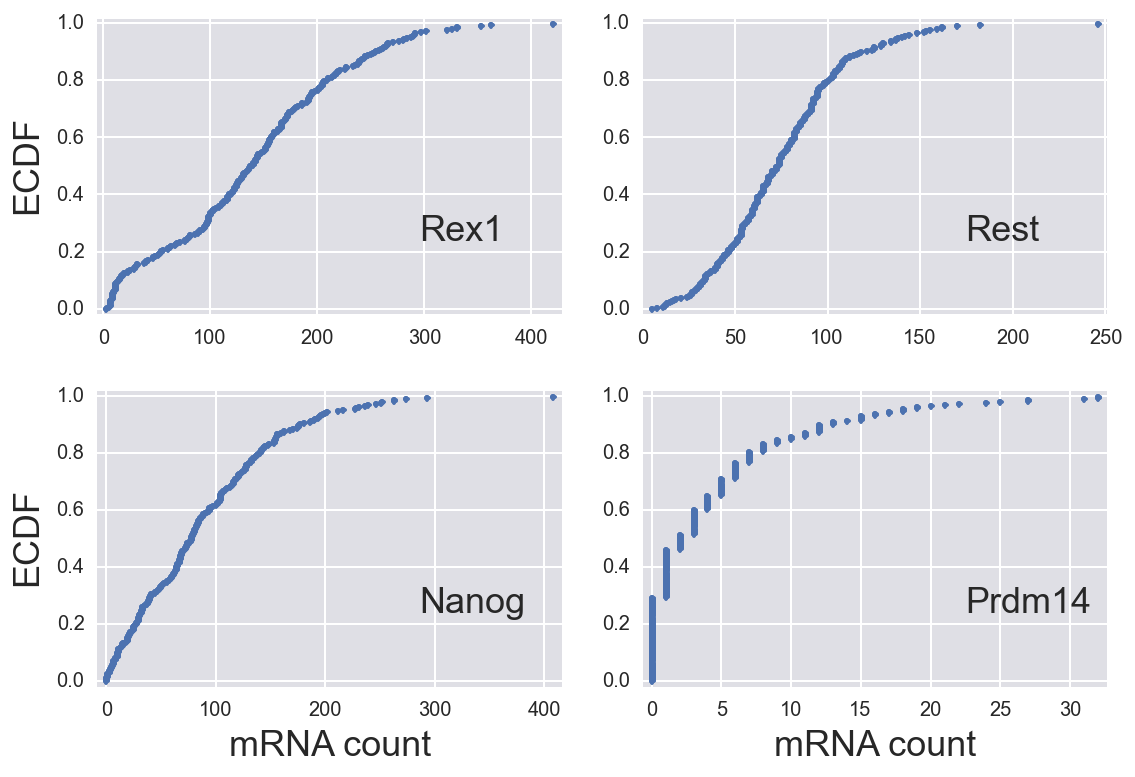

In [2]:
# Load DataFrame
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv', 
                 comment='#')

# Make plots of ECDFs
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout(w_pad=2, h_pad=2)

The double inflection points for Rex1 suggest bimodality.  The others seem to be unimodal, but as we saw in [Tutorial 4a](t4a_param_est_mle.html#Graphical-evaluation-of-the-MLE) that it is not obvious that they actually are unimodal.  So, we want to rigorously compute an odds ratio to discern unimodality from bimodality.

## Model selection of the Singer, et al. data

We will define Model A to be a single negative binomial distribution and Model B to be a double negative binomial.  As before, since we don't have a preference for either model a priori, we we will take $P(A\mid I) \approx P(B\mid I)$.  We will take uniform priors for $p$, $p_1$, and $p_2$ on the interval $[0,1]$.  Similarly, we will take $f$ to have a uniform prior on $[0,1]$.  We will take uniform priors for $r$, $r_1$, and $r_2$ on the interval $[0, r_\mathrm{max}]$, where $r_\mathrm{max}$ is the most bursts we would expect during an mRNA lifetime. 

To estimate $r_\mathrm{max}$, we will refer to the excellent [BioNumbers website](http://bionumbers.hms.harvard.edu/).  The typical mRNA degradation time in mice, is [9 hours](http://bionumbers.hms.harvard.edu/bionumber.aspx?&id=106378).  A burst every half hour seems pretty fast to me, so we'll estimate $r_\mathrm{max} \approx 20$ and use this in our calculations.

So, to do model selection, we need to solve the parameter estimation problem using PTMCMC for each model.  We'll do this first for Rex 1.

### Computing the log likelihood stably
In [Tutorial 5a](t5a_model_selection_1.html), we computed the log likelihood as follows.

In [3]:
def log_likelihood_t5a(params, n, model):
    """
    Log likelihood for negative binomial distributed parameters.
        params = np.array([r_1, p_1, r_2, p_2, f])
    """
    if model == 'A':
        return st.nbinom.logpmf(n, params[0], params[1]).sum()
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        return np.log(f * st.nbinom.pmf(n, r_1, p_1)
                      + (1-f) * st.nbinom.pmf(n, r_2, p_2)).sum()
    else:
        raise RuntimeError('Invalid model.')

For Model B, we sum two quantities and then take the logarithm.  This could be a problem if `st.nbinom.pmf()` returns very small values.  In this case, we essentially get a log of zero, which will give $-\infty$ for the log likelihood.  We need to avoid this issue.  We would like to use only the `st.nbinom.logpmf()` function.  To do this, we need to re-write our likelihood.  Let 

\begin{align}
\xi_1 &= \ln\left(\frac{\Gamma(n+r_1)}{n!\,\Gamma(r_1)}\,p_1^{r_1}(1-p_1)^{n}\right),\\[1em]
\text{and } \xi_2 &= \ln\left(\frac{\Gamma(n+r_2)}{n!\,\Gamma(r_2)}\,p_2^{r_2}(1-p_2)^{n}\right).
\end{align}

Here, $\xi_1$ and $\xi_2$ are what is returned by `st.nbinom.logpmf()`.
Then,

\begin{align}
P(n\mid r_1, p_1, r_2, p_2, f) = f \mathrm{e}^{\xi_1} + (1-f)\mathrm{e}^{\xi_2} 
= \mathrm{e}^{\xi_1 + \ln f} + \mathrm{e}^{\xi_2 + \ln(1-f)}.
\end{align}

So, we can compute the log likelihood as the log of a sum of exponentials.

\begin{align}
\ln (n\mid r_1, p_1, r_2, p_2, f) = \ln\left(\mathrm{e}^{\xi_1 + \ln f} + \mathrm{e}^{\xi_2 + \ln(1-f)}\right).
\end{align}

There is a NumPy function, `np.logaddexp()` to stably compute the log of the sum of exponentials.  We will utilize this in our likelihood.  We call name the function with the `_slow` label because we will speed it up in a moment.

In [4]:
def log_likelihood_slow(params, n, model):
    """
    Log likelihood for negative binomial distributed parameters.
        params = np.array([r_1, p_1, r_2, p_2, f])
    """
    if model == 'A':
        return st.nbinom.logpmf(n, params[0], params[1]).sum()
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        return np.logaddexp(st.nbinom.logpmf(n, r_1, p_1) + np.log(f),
                            st.nbinom.logpmf(n, r_2, p_2) + np.log(1-f)).sum()
    else:
        raise RuntimeError('Invalid model.')

We'll do a quick check to make sure we get the same values.

In [5]:
# Test parameters to use
test_params = np.array([7.3, 0.3, 4.3, 0.2, 0.5])

# Print results
print(log_likelihood_t5a(test_params, 500, 'B'))
print(log_likelihood_slow(test_params, 500, 'B'))

-100.844165997
-100.844165997


Success!  Now, we'll try to make the log likelihood faster, since speed is of the essence, especially now that we're doing parallel tempering.

### Speeding up the log likelihood computation
We can use lower level functions in the `scipy.stats` module that do not do error checking to get a speed boost.  To do this, we use, `scipy.stats.nbinom._logpmf()` instead of `scipy.stats.nbinom.logpmf()`; note the underscore.  We'll define a new log likelihood function and do a quick speed test to see what speed boost we might expect.

In [6]:
def log_likelihood(params, n, model):
    """
    Log likelihood for negative binomial distributed parameters.
        params = np.array([r_1, p_1, r_2, p_2, f])
    """
    if model == 'A':
        return st.nbinom._logpmf(n, params[0], params[1]).sum()
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        return np.logaddexp(st.nbinom._logpmf(n, r_1, p_1) + np.log(f),
                            st.nbinom._logpmf(n, r_2, p_2) + np.log(1-f)).sum()
    else:
        raise RuntimeError('Invalid model.')
        
# Run speed tests
print('Slow method:')
%timeit log_likelihood_slow(np.array([7.3, 0.3, 4.3, 0.2, 0.5]), 500, 'B')

print('Faster method:')
%timeit log_likelihood(np.array([7.3, 0.3, 4.3, 0.2, 0.5]), 500, 'B')

Slow method:
10000 loops, best of 3: 184 µs per loop
Faster method:
10000 loops, best of 3: 22.3 µs per loop


This is almost a 10-fold speed boost, so we'll take it.  **Warning: Do this at your own risk!**  Never do this during development.  Only do it if you are absolutely certain that you will always give the function appropriate inputs.

### The prior
Now, we have to code up the prior.  Remember, we defined $p_1 > p_2$ in our double negative binomial model.

In [7]:
def log_prior(params, r_max, model):
    """
    Log prior for negative binomially distributed bursty gene expression.
    params = [p1, r1, p2, r2, f]
    """
    if (params < 0).any() or params[0] > r_max or params[1] > 1:
        return -np.inf
    
    if model == 'A':
        return -np.log(r_max)
    elif model == 'B':
        r_1, p_1, r_2, p_2, f = params
        if p_1 < p_2 or f > 1 or r_2 > r_max:
            return -np.inf
        return -2 * np.log(r_max)

When we use PTMCMC, we do not need to code up a posterior, just the likelihood and prior.  So, we can now write a function to run the PTMCMC calculation.

### Doing the PTMCMC calculation
We will use the utility function `bebi103.run_pt_emcee()` to perform the PTMCMC calculations.  You should review its doc string to see how to call it.  If you have not yet downloaded it, you may do so [here](https://github.com/justinbois/bebi103_utils).  I highly recommend you use Git to do this, since I will be updating this file as we head into the image processing part of the course.  To do this, do the following:

    git clone https://github.com/justinbois/bebi103_utils.git
    
You can then do `git pull` whenever there are updates.

Now, do our function to do PTMCMC for the Singer, et al. samples.

In [8]:
def sample_ptmcmc(n, model, r_max=20, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample postrior using PTMCMC.
    
    n = array of mRNA counts in cells
    """
    # Arguments for likelihood
    loglargs = (n, model)
    
    # Arguments for prior
    logpargs = (r_max, model)
    
    # Columns headings for outputted DataFrames
    columns = {'A': ['r', 'p'],
               'B': ['r1', 'p1', 'r2', 'p2', 'f']}
        
    # Parameters and how we start them
    if model == 'A':
        # Build p0
        p0 = np.empty((n_temps, n_walkers, 2))
        p0[:,:,0] = np.random.uniform(0, r_max, (n_temps, n_walkers))  # r
        p0[:,:,1] = np.random.uniform(0, 1, (n_temps, n_walkers))      # p

        # Get samples
        return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps, n_temps=n_temps, 
            n_walkers=n_walkers, p0=p0, columns=columns[model],
            loglargs=loglargs, logpargs=logpargs, threads=threads, 
            return_lnZ=True)
    elif model == 'B':
        # Build p0
        p0 = np.empty((n_temps, n_walkers, 5))
        p0[:,:,0] = np.random.uniform(0, r_max, (n_temps, n_walkers))  # r1
        p0[:,:,1] = np.random.uniform(0, 1, (n_temps, n_walkers))      # p1
        p0[:,:,2] = np.random.uniform(0, r_max, (n_temps, n_walkers))  # r2
        p0[:,:,3] = np.random.uniform(0, 1, (n_temps, n_walkers))      # p2
        p0[:,:,4] = np.random.uniform(0, 1, (n_temps, n_walkers))      # f

        # Make sure p1 > p2
        p0[:,:,1], p0[:,:,3] = np.maximum(p0[:,:,1], p0[:,:,3]), \
                                np.minimum(p0[:,:,1], p0[:,:,3])
    
        return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            threads=threads, columns=columns[model], return_lnZ=True)

### PTMCMC for Rex1
We'll now use our handy functions to perform PTMCMC for the Rex1 gene.  The calculation is lengthy.  We will to 1000 burn-in steps and 10000 sampling steps with 100 walkers.  Provided we burned in long enough, we will get a million samples of the cold distribution.  We will have a total of $2\times 10^7$ samples over all temperatures, which is a lot of MCMC sampling!

In [9]:
# Specify gene
gene = 'Rex1'

# Sample both models using PTMCMC; This will take a long time
df_A, lnZ_A, dlnZ_A = sample_ptmcmc(df[gene].values, 'A', threads=6, 
                                    n_burn=1000, n_steps=10000)

df_B, lnZ_B, dlnZ_B = sample_ptmcmc(df[gene].values, 'B', threads=6,
                                    n_burn=1000, n_steps=10000)

Now that we have these samples, we can compute the posterior probabilities and do the usual plotting for the parameter estimation problem.  We pull out the cold distribution by indexing, e.g., `df_A[df_A.beta_ind==0]`.  First, we'll make a triangle plot for model A.

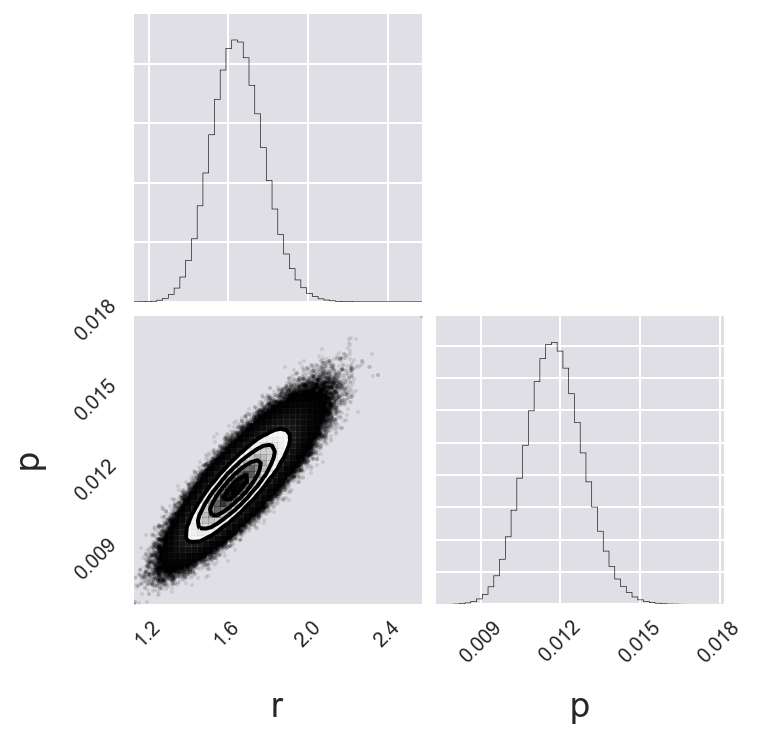

In [10]:
corner.corner(df_A[df_A.beta_ind==0][['r', 'p']], bins=50);

And now for model B.

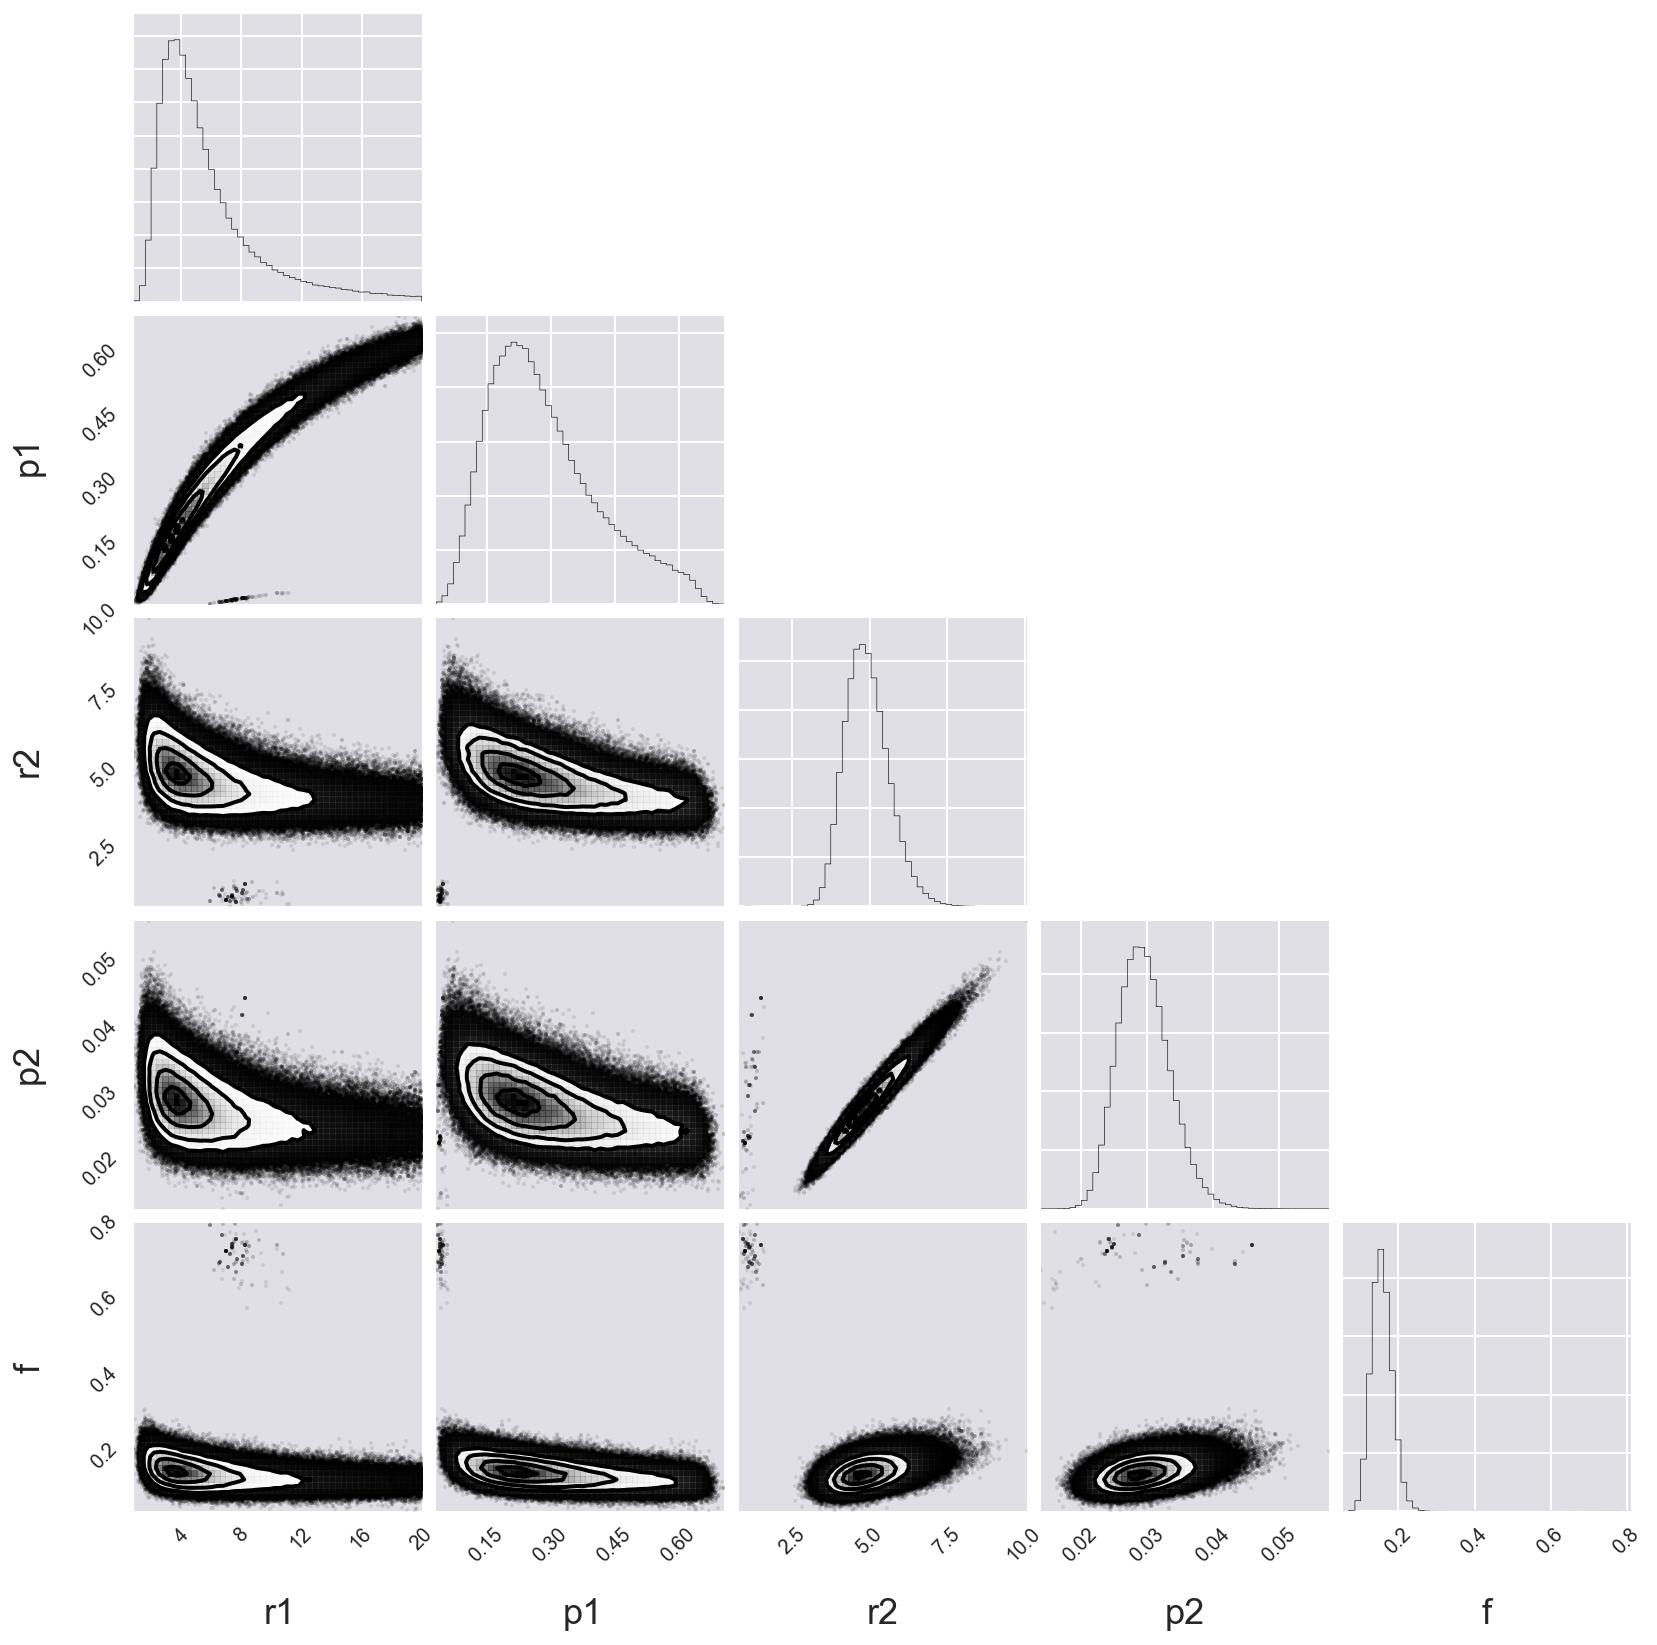

In [11]:
corner.corner(df_B[df_B.beta_ind==0][['r1', 'p1', 'r2', 'p2', 'f']], bins=50);

All of the marginalized posteriors are unimodal, which allows us to cleanly parametrize model B.

We can plot smooth CDFs using the parameters we got from the MCMC calculation.  We will write a function to do it, since we will use it more later.

In [34]:
def plot_fits(df, df_A, df_B, gene, show=(1, 1), ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Indices for MCMC trace
    inds = df_A['beta_ind'] == 0

    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)

    # Plot ECDF
    ax.plot(x, y, '.', zorder=2)
    ax.margins(0.02)

    # Overlay theoretical CDFs
    if show[0]:
        plot_inds = np.random.choice(np.arange(np.sum(inds), dtype=int), 500)
        n_plot = np.arange(0, df[gene].max()+1)
        for ind in plot_inds:
            r, p = df_A[inds][['r', 'p']].iloc[ind].values.flatten()
            ax.plot(n_plot, st.nbinom.cdf(n_plot, r, p), '-', lw=0.2, 
                     alpha=0.2, color=sns.color_palette()[2], zorder=1)

    # Build theroetical PMF
    if show[1]:
        cols = ['r1', 'r2', 'p1', 'p2', 'f']
        inds = df_B['beta_ind'] == 0
        plot_inds = np.random.choice(np.arange(np.sum(inds), dtype=int), 500)
        n_plot = np.arange(0, df[gene].max()+1)
        for ind in plot_inds:
            r_1, r_2, p_1, p_2, f = df_B[inds][cols].iloc[ind].values.flatten()
            cdf = f * st.nbinom.cdf(n_plot, r_1, p_1) +\
                (1-f) * st.nbinom.cdf(n_plot, r_2, p_2)
            ax.plot(n_plot, cdf, '-', lw=0.2, alpha=0.2, 
                     color=sns.color_palette()[5], zorder=1)
            
    # Label axes
    ax.set_xlabel('num. of mRNA transcripts')
    ax.set_ylabel('cdf')

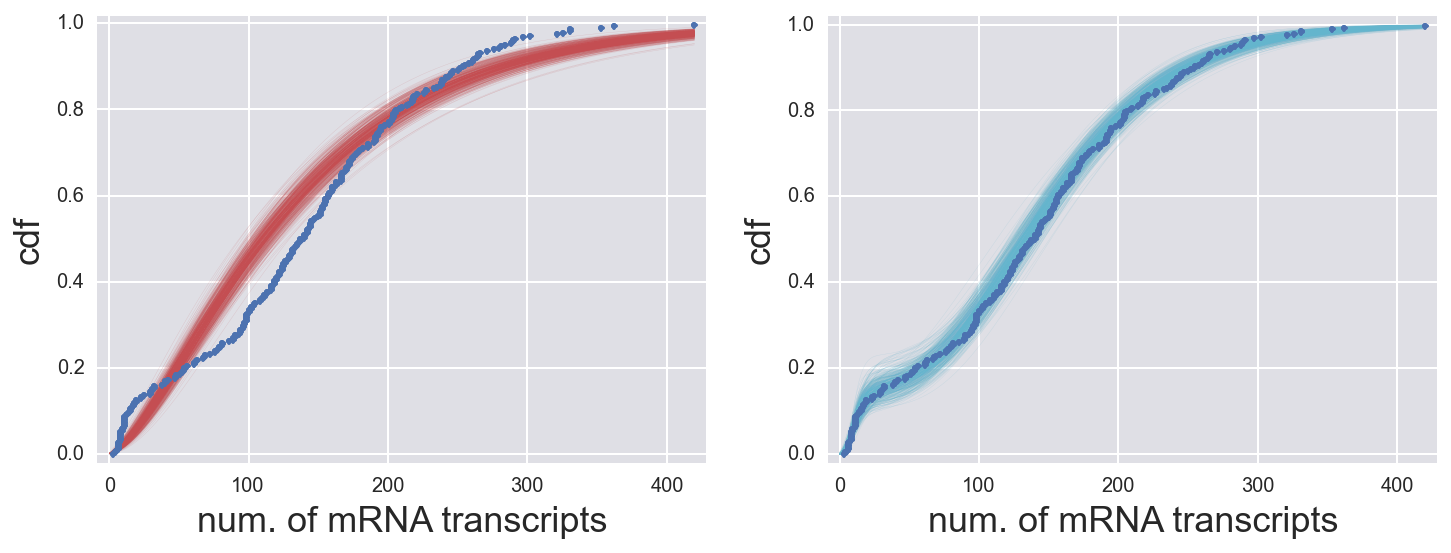

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0] = plot_fits(df, df_A, df_B, gene, show=(1,0), ax=ax[0])
ax[1] = plot_fits(df, df_A, df_B, gene, show=(0,1), ax=ax[1])

We see that the unimodal distribution cannot fit the data, but the bimodal does.  Let's now compute our goal: the odds ratio!  It is easy now that we have `lnZ`.

In [14]:
print('Odds ratio:', np.exp(lnZ_A - lnZ_B))

Odds ratio: 1.65148225273e-19


We get an odds ratio of about $10^{-19}$, which is close to the result we got with an approximate calculation in [Tutorial 5a](t5a_model_selection_1.html#Analysis-for-Rex1).  There are clearly more than one type of cell when considering Rex1 expression.

### Analysis of Prdm14

We will do the same analysis with Prdm14, which showed qualitatively single negative binomial behavior.  Before we do, let's save our results from Rex1 in a dictionary.

In [15]:
results = {'Rex1': {'lnZ_A': lnZ_A,
                    'dlnZ_A': dlnZ_A,
                    'lnZ_B': lnZ_B,
                    'dlnZ_B': dlnZ_B,
                    'df_A': df_A.copy(),
                    'df_B': df_B.copy()}}

Now we'll run the calculation for Prdm14 and store the results in the `results` dictionary.

In [16]:
gene = 'Prdm14'

# Sample both models using PTMCMC; This will take a long time
df_A, lnZ_A, dlnZ_A = sample_ptmcmc(df[gene].values, 'A', threads=6, 
                                    n_burn=1000, n_steps=10000)

df_B, lnZ_B, dlnZ_B = sample_ptmcmc(df[gene].values, 'B', threads=6,
                                    n_burn=1000, n_steps=10000)

# Store results in dictionary
results[gene] = {'lnZ_A': lnZ_A,
                 'dlnZ_A': dlnZ_A,
                 'lnZ_B': lnZ_B,
                 'dlnZ_B': dlnZ_B,
                 'df_A': df_A.copy(),
                 'df_B': df_B.copy()}

We looked at the corner plot before using an ensemble sampler.  We'll look again to see if it is just as nasty.

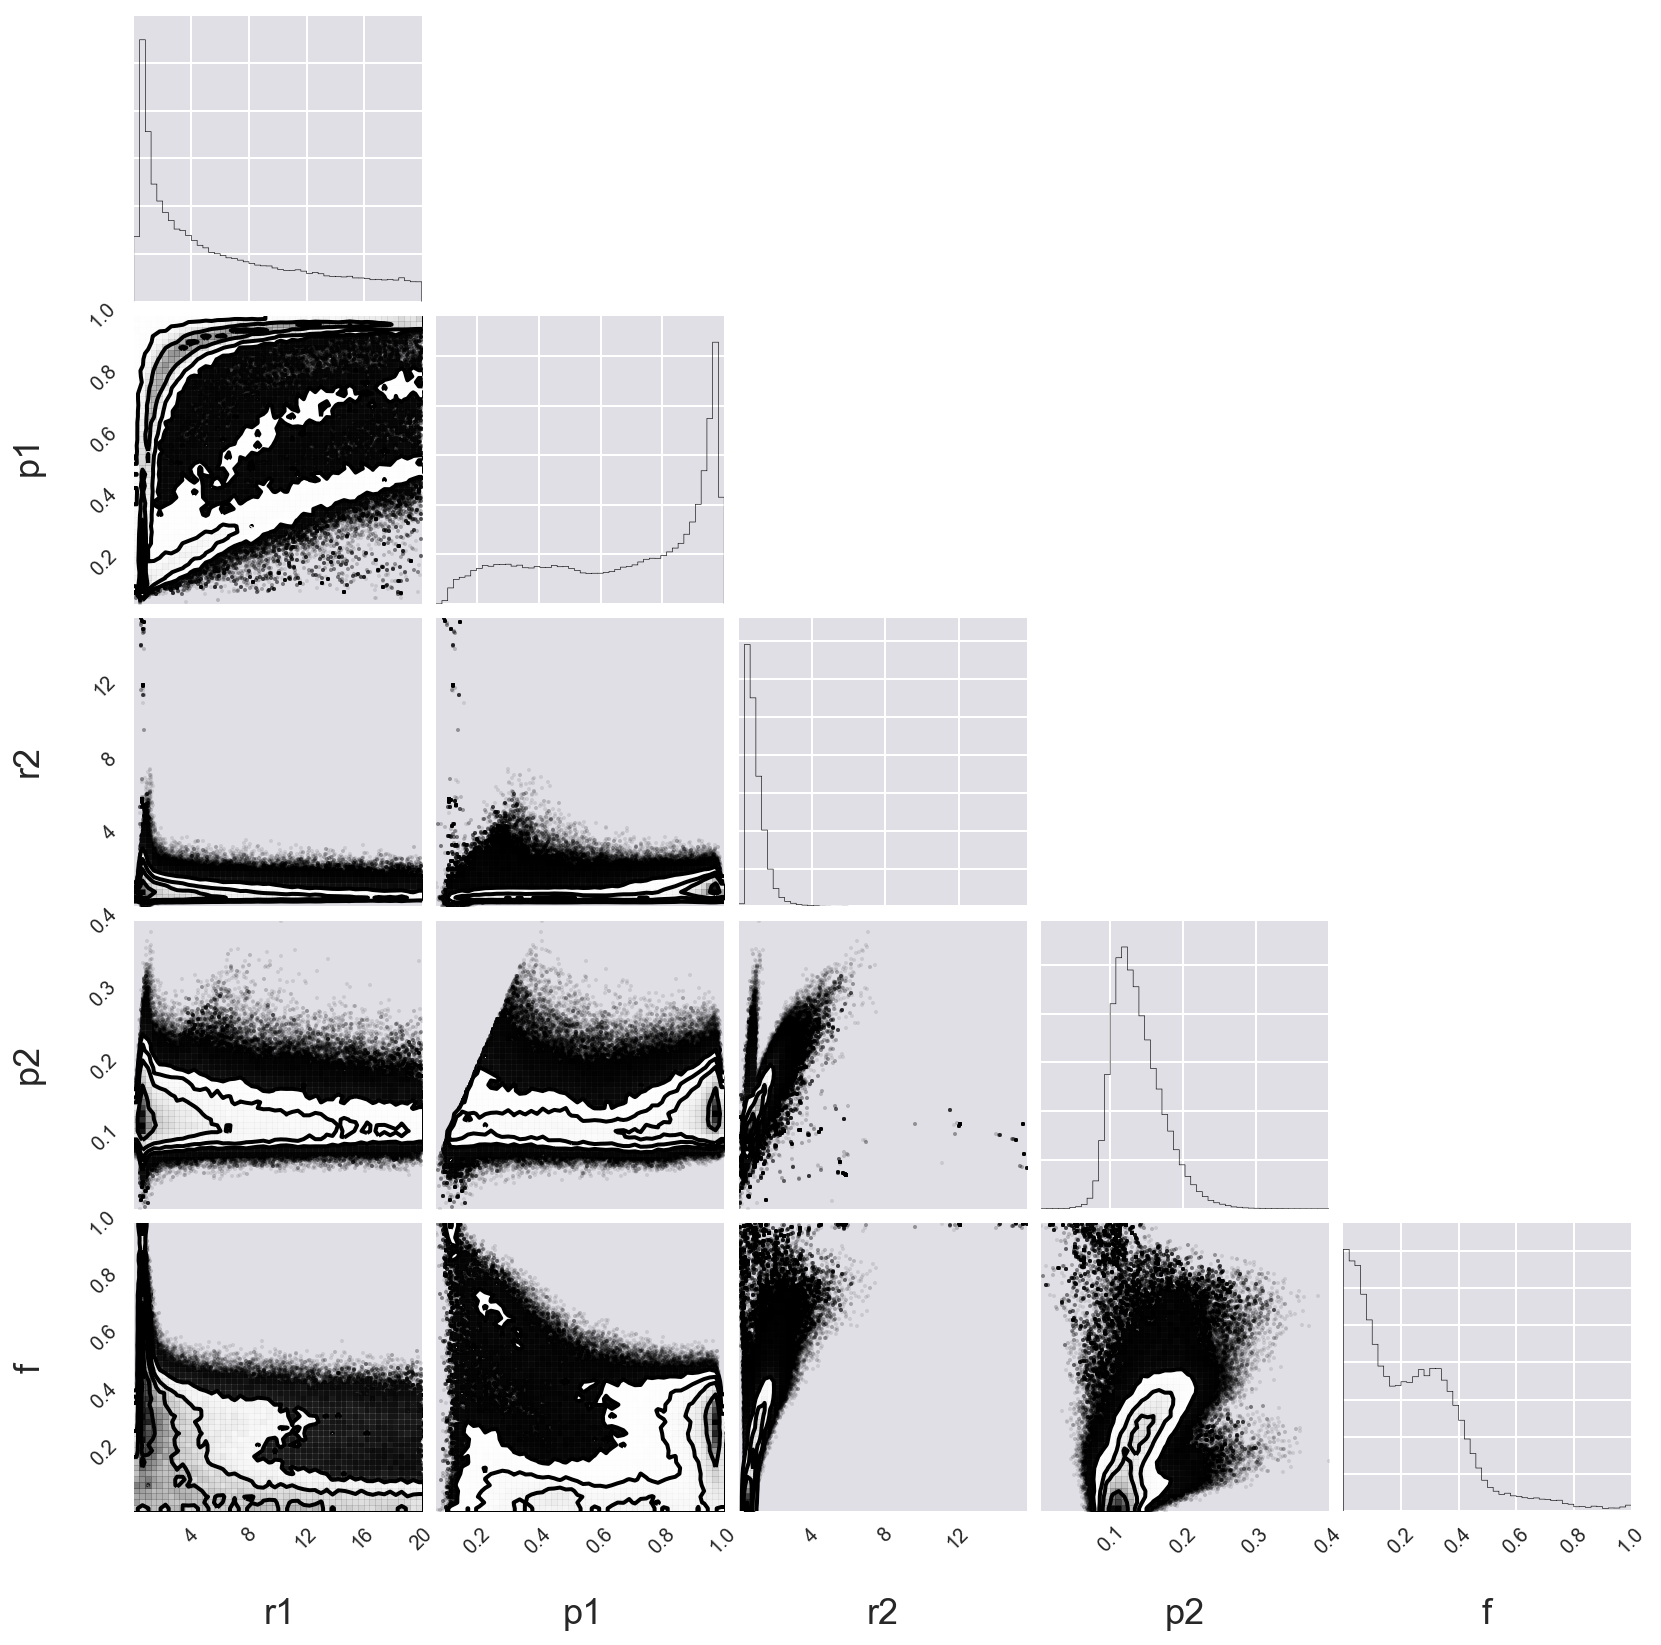

In [17]:
corner.corner(df_B[df_B.beta_ind==0][['r1', 'p1', 'r2', 'p2', 'f']], bins=50);

The posterior has a broad shape, particularly in parameters $r_1$, $p_1$, and $f$.  If the underlying distribution is bimodal, we would not be able to clearly parametrize it and would instead have to show plots of the posterior.

For completeness, let's look at the triangle plot for model A.

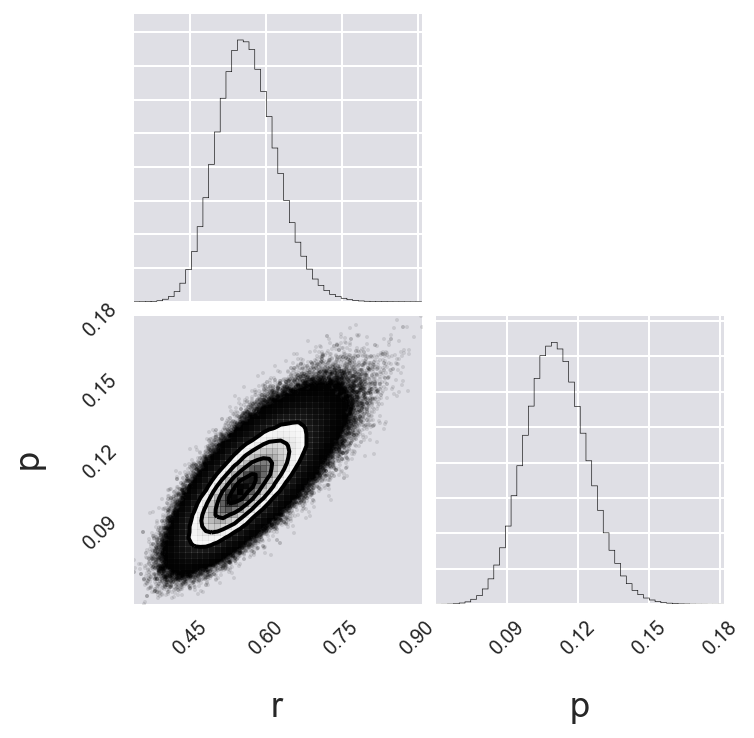

In [38]:
corner.corner(df_A[df_A.beta_ind==0][['r', 'p']], bins=50);

Here, we have a unimodal posterior and we can cleanly parametrize the distribution of mRNA counts for Prdm14.

We can also compare the respective fits.

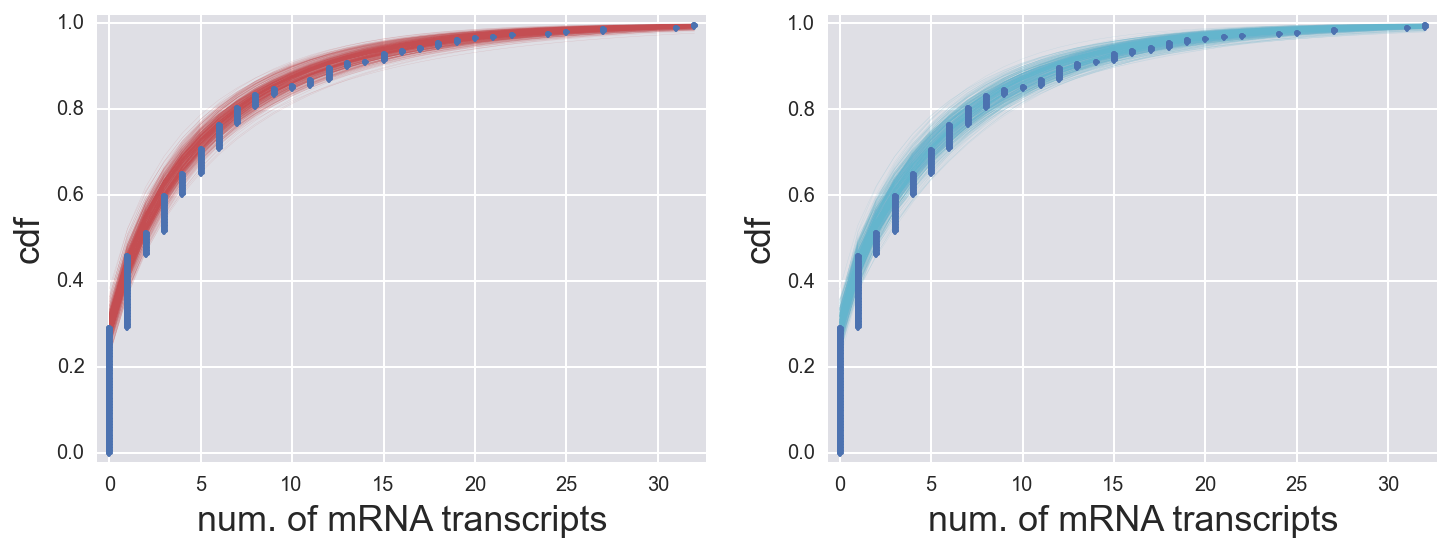

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0] = plot_fits(df, df_A, df_B, gene, show=(1,0), ax=ax[0])
ax[1] = plot_fits(df, df_A, df_B, gene, show=(0,1), ax=ax[1])

It is hard to tell the difference between the two fits.  We might expect an Occam penalty to therefore make the single exponential fit more likely.  Let's compute the odds ratio and see.

In [19]:
print('Odds ratio:', np.exp(lnZ_A - lnZ_B))

Odds ratio: 5.91144607326


Indeed, the single negative binomial distribution is more likely, by about a factor of 6.  While this tips the odds in favor of a single exponential model, it is not overwhelmingly convincing.  We might want to try to do more experiments.

### Analysis of Nanog and Rest

We'll finish our analysis by doing model selection on the Nanog and Rest counts.

In [20]:
for gene in ['Nanog', 'Rest']:
    # Sample both models using PTMCMC; This will take a long time
    df_A, lnZ_A, dlnZ_A = sample_ptmcmc(df[gene].values, 'A', threads=6, 
                                        n_burn=1000, n_steps=10000)

    df_B, lnZ_B, dlnZ_B = sample_ptmcmc(df[gene].values, 'B', threads=6,
                                        n_burn=1000, n_steps=10000)

    # Store results in dictionary
    results[gene] = {'lnZ_A': lnZ_A,
                     'dlnZ_A': dlnZ_A,
                     'lnZ_B': lnZ_B,
                     'dlnZ_B': dlnZ_B,
                     'df_A': df_A.copy(),
                     'df_B': df_B.copy()}

Let's plot the triangle plots, first for Nanog.

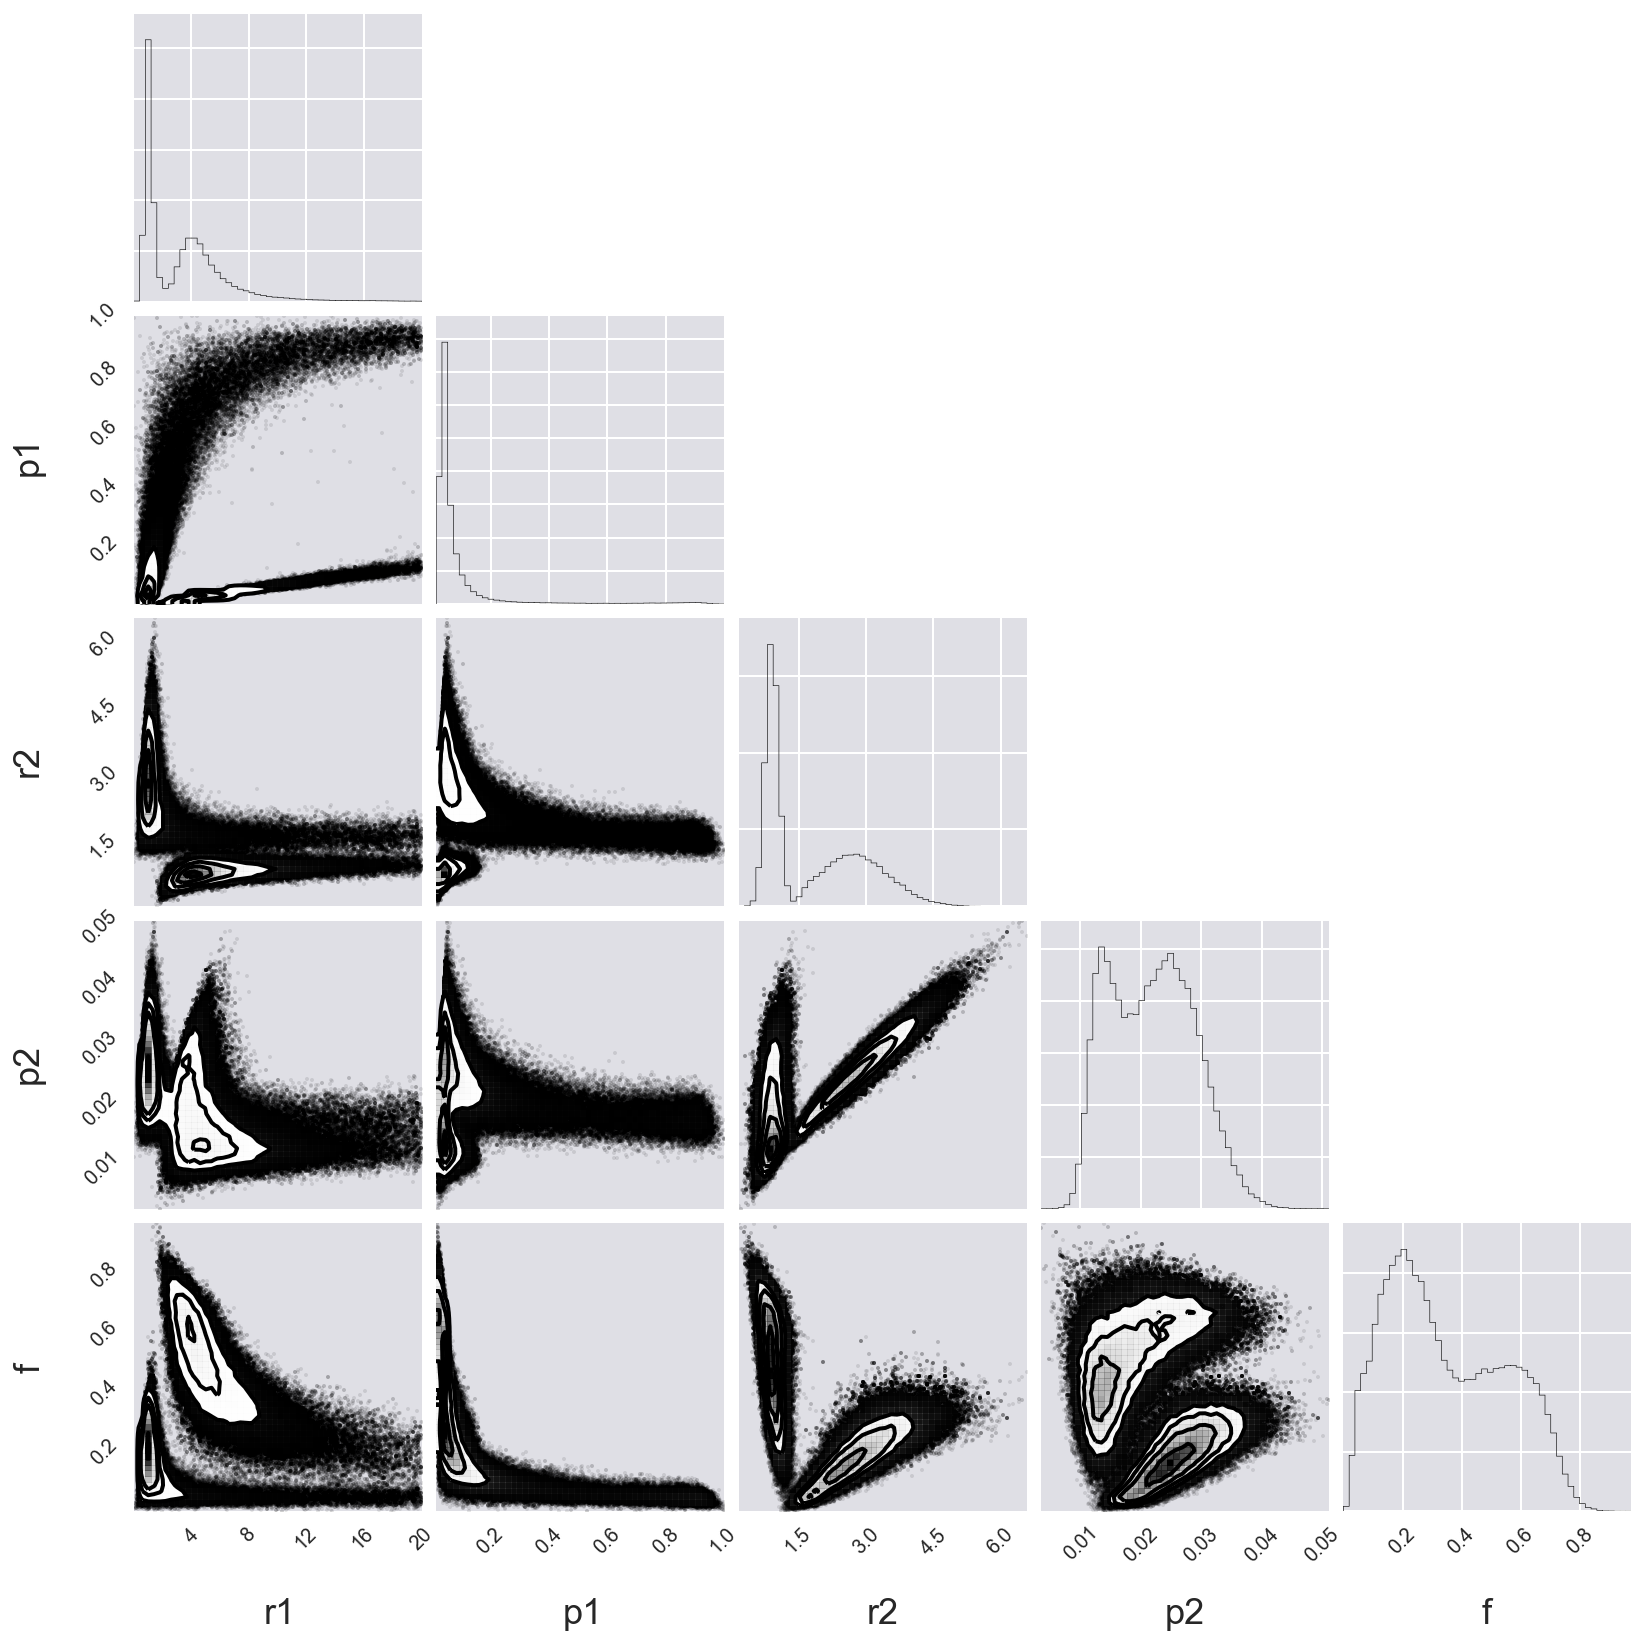

In [31]:
df_B = results['Nanog']['df_B']
corner.corner(df_B[df_B.beta_ind==0][['r1', 'p1', 'r2', 'p2', 'f']], bins=50);

We see some qualitative similarities to the Rex1 posterior.  We also see that pretty much any value of $f$ goes and that $p_1$ and $p_2$ are both small.  The burst size distributions are also strongly bimodal.  Again, this precludes a clean parametrization of the posterior, so we should show the posterior if we do believe that the Nanog mRNA distribution is bimodal.  

Note that this calls into question results from MLE, since the posterior is so clearly multimodal.  This also demonstrates the utility of PTMCMC, which allows for multimodal sampling.

Again, for completeness, we'll look at the posterior for the unimodal distribution.

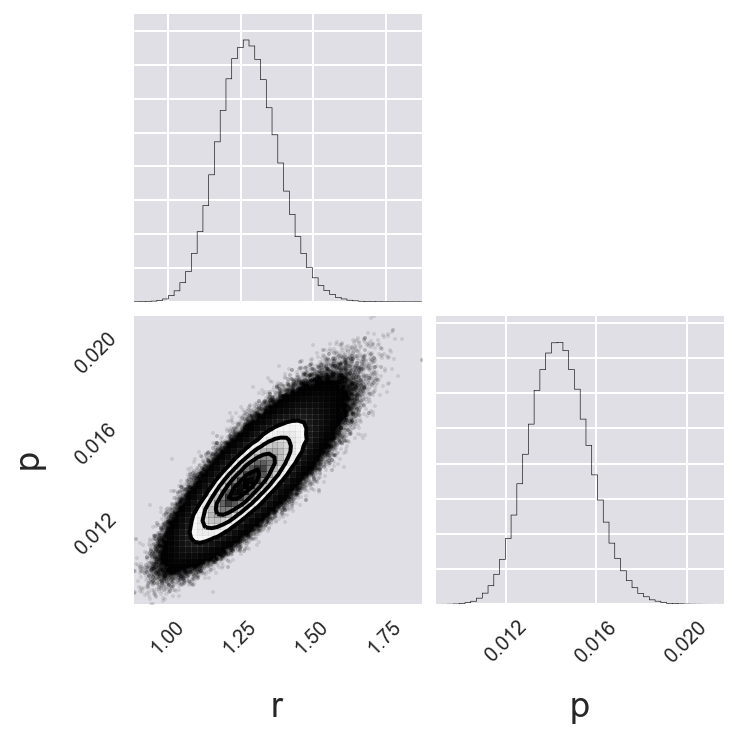

In [39]:
df_A = results['Nanog']['df_A']
corner.corner(df_A[df_A.beta_ind==0][['r', 'p']], bins=50);

As we might expect, it is also unimodal like Rex1 and Prdm14..

Now let's look at Rest.

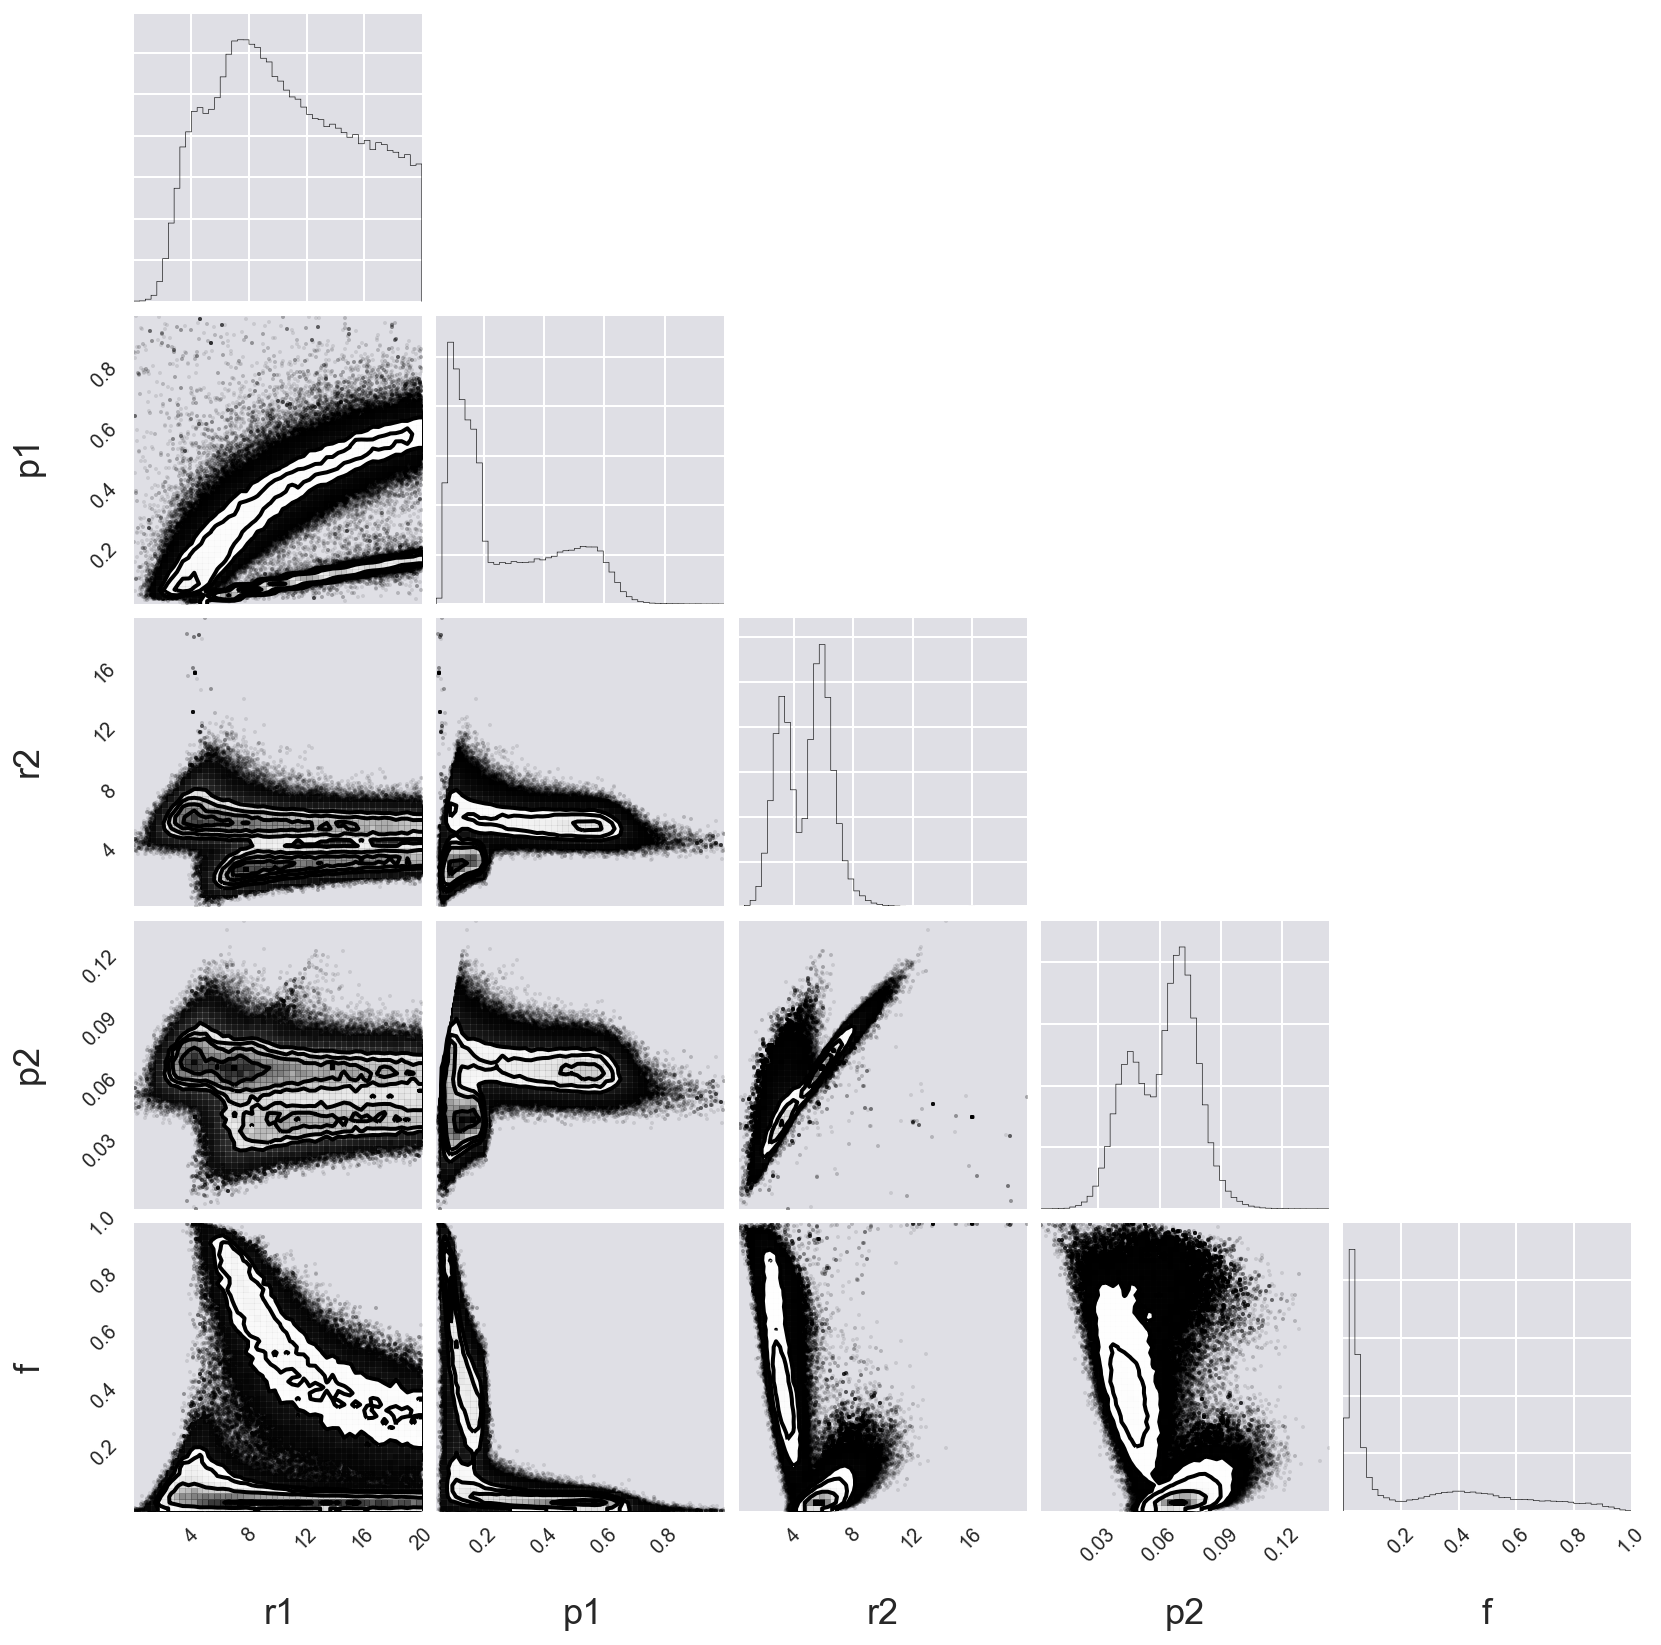

In [22]:
df_B = results['Rest']['df_B']
corner.corner(df_B[df_B.beta_ind==0][['r1', 'p1', 'r2', 'p2', 'f']], bins=50);

Again, we have a multimodal posterior.  We'll do another quick check of the posterior for model A.

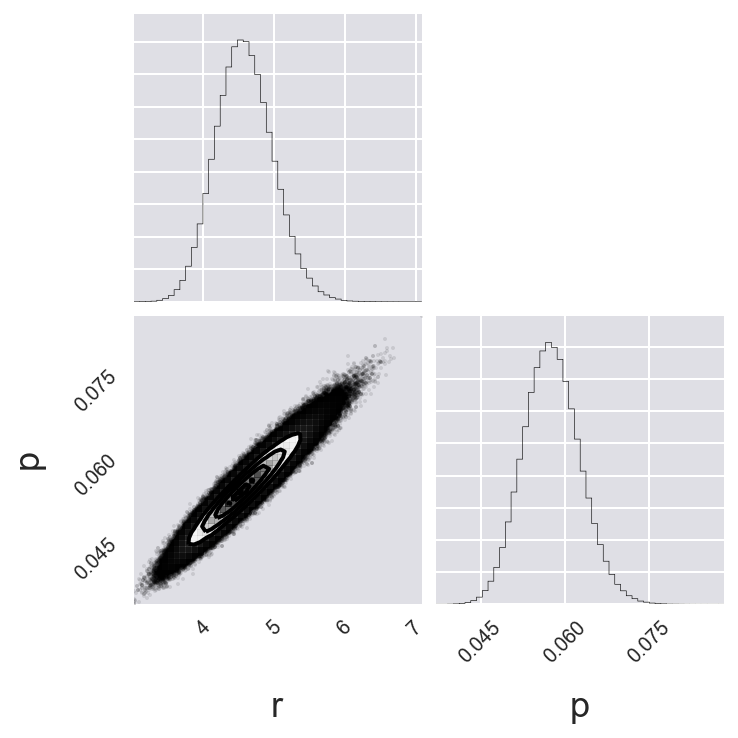

In [40]:
df_A = results['Rest']['df_A']
corner.corner(df_A[df_A.beta_ind==0][['r', 'p']], bins=50);

Let's look at the curve fits, first for Nanog.

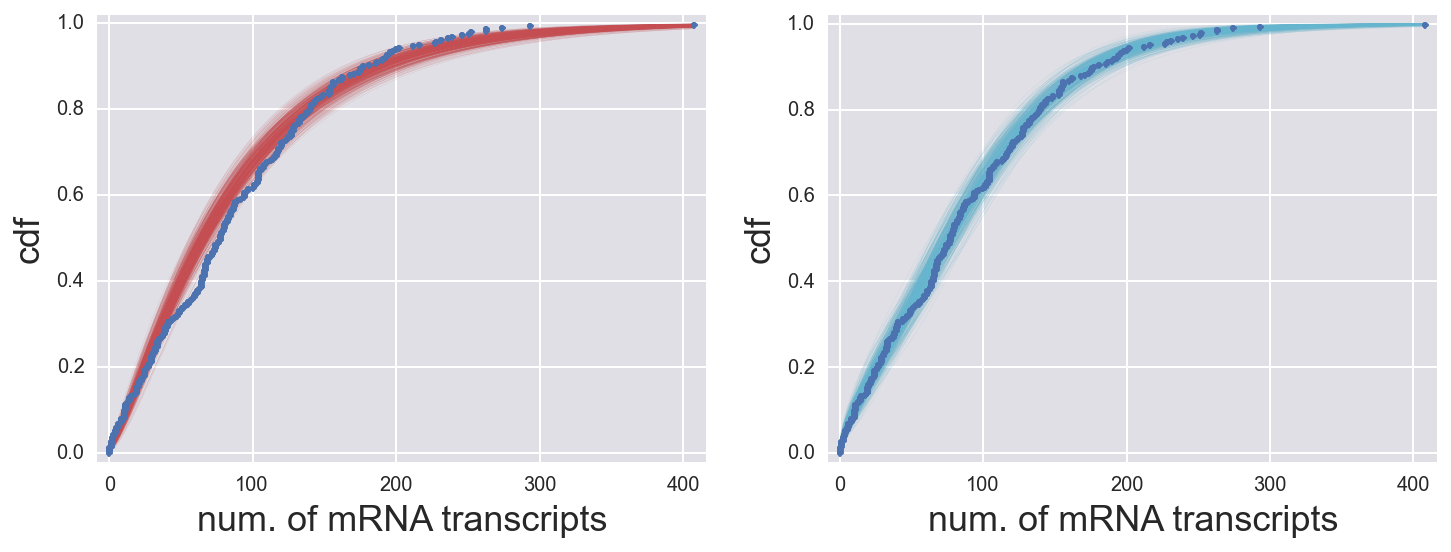

In [23]:
gene = 'Nanog'
df_A = results[gene]['df_A']
df_B = results[gene]['df_B']
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0] = plot_fits(df, df_A, df_B, gene, show=(1,0), ax=ax[0])
ax[1] = plot_fits(df, df_A, df_B, gene, show=(0,1), ax=ax[1])

We see some systematic failure of the unimodal curve to capture the Nanog data.  The bimodal fit works better.  This should play out in the odds ratio.

Now, let's look at the curve fits for Rest.

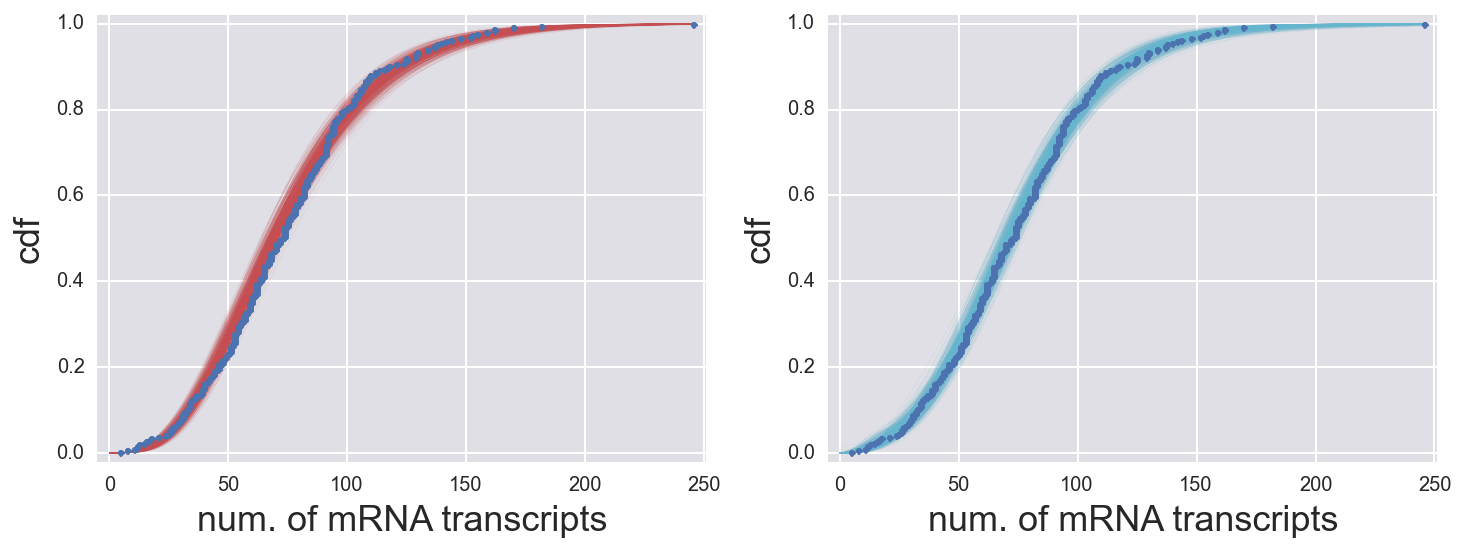

In [24]:
gene = 'Rest'
df_A = results[gene]['df_A']
df_B = results[gene]['df_B']
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0] = plot_fits(df, df_A, df_B, gene, show=(1,0), ax=ax[0])
ax[1] = plot_fits(df, df_A, df_B, gene, show=(0,1), ax=ax[1])

We do see some systematic error in the unimodal distribution, but not as bad as in the Rex1 or Nanog examples.

Ok, now let's compute the odds ratios!  We'll do them all to provide a summary.  Remember that $O_{AB} > 1$ implies a unimodal distribution and $O_{AB} < 1$ implies a bimodal distribution.

In [30]:
for gene in df.columns:
    print('Odds ratio for {0:s}: {1:.2e}'.format(gene,
          np.exp(results[gene]['lnZ_A'] - results[gene]['lnZ_B'])))

Odds ratio for Rex1: 1.65e-19
Odds ratio for Rest: 3.12e-01
Odds ratio for Nanog: 1.13e-03
Odds ratio for Prdm14: 5.91e+00


So, Rex1 is surely bimodal, and it is quite likely that Nanog is as well.  For Rest and Prdm14, the odds ratio is not really conclusive.  It is more likely that not that Rest is bimodal and Prdm14 is unimodal, but that is about all we can say.